In [20]:
!pip install datasets torchvision scikit-image matplotlib

In [21]:
from datasets import load_dataset

# Load satellite imagery dataset
dataset = load_dataset("subhuatharva/amazon_from_space")
dataset = dataset['train']  # We'll use the training portion for demo

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
import base64

# Convert PIL Image to NumPy array and normalize
def preprocess_image(example, resize=(128, 128)):
    # The 'image' column contains base64 encoded image strings
    image_data = base64.b64decode(example['image'])  # Decode the string to bytes
    image = Image.open(BytesIO(image_data)).convert('RGB') # Open the bytes as an image
    transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    return image_tensor.numpy()

# Pick two images for change detection simulation
img1 = preprocess_image(dataset[0])
img2 = preprocess_image(dataset[1])

In [23]:
def detect_change_rgb(img1, img2, threshold=0.1):
    diff = np.abs(img2 - img1)
    change_map = np.mean(diff, axis=0) > threshold
    return change_map

change_mask = detect_change_rgb(img1, img2)


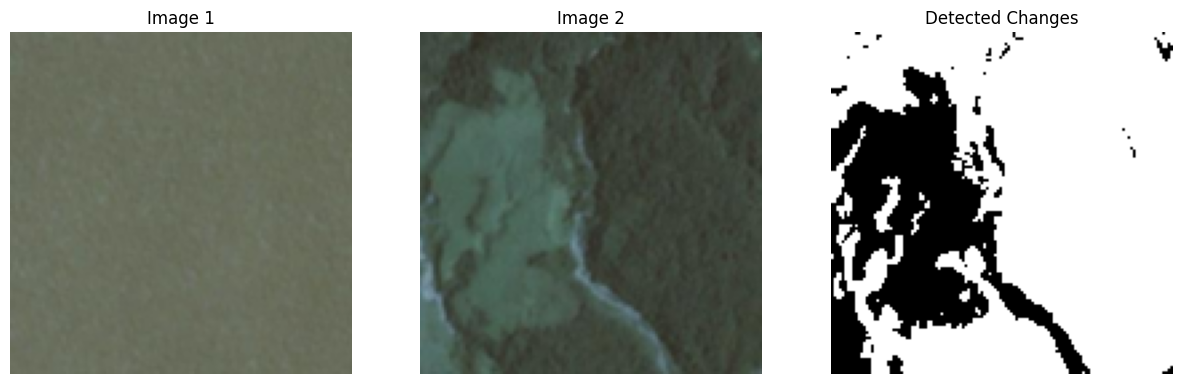

In [24]:
def plot_rgb_change(img1, img2, change_mask):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(np.transpose(img1, (1, 2, 0)))
    axs[0].set_title("Image 1")
    axs[1].imshow(np.transpose(img2, (1, 2, 0)))
    axs[1].set_title("Image 2")
    axs[2].imshow(change_mask, cmap='gray')
    axs[2].set_title("Detected Changes")
    for ax in axs:
        ax.axis('off')
    plt.show()

plot_rgb_change(img1, img2, change_mask)

In [25]:
print(dataset[0]['tags'])
# Example: ['primary', 'clear', 'agriculture']

haze primary


In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataset['tags'])

# Confirm classes
print("Classes:", mlb.classes_)

Classes: [' ' '_' 'a' 'b' 'c' 'd' 'e' 'g' 'h' 'i' 'l' 'm' 'n' 'o' 'p' 'r' 's' 't'
 'u' 'v' 'w' 'y' 'z']


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class AmazonDataset(Dataset):
    def __init__(self, hf_dataset, labels, transform):
        self.dataset = hf_dataset
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.transform(self.dataset[idx]['image'])
        label = torch.tensor(self.labels[idx]).float()
        return image, label

train_dataset = AmazonDataset(dataset, y, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [28]:
import torch.nn as nn

class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256), nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Sigmoid()  # for multi-label
        )

    def forward(self, x):
        return self.model(x)

num_classes = len(mlb.classes_)
model = MultiLabelCNN(num_classes).to("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# Check the first item in the dataset
print(dataset[0])

{'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDKUkgjrSPkDnrSDOQwpWYHPrWIgPK5pynCbTyO1RYyMZ57U4ZHU5xxQFg3tjpxTlO4YpO+O1L0JpCFyNox1pp6HuaSMU71xQMRG3NyKkbbniothBzTuTk07gH3cZpQTj2pnPII5pQeMUAH8VOXI+lAHGaQcuPSk

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from io import BytesIO
import base64

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class AmazonDataset(Dataset):
    def __init__(self, hf_dataset, labels, transform):
        self.dataset = hf_dataset
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Decode the base64 image string and open it as a PIL Image
        image_data = base64.b64decode(self.dataset[idx]['image'])
        image = Image.open(BytesIO(image_data)).convert('RGB')
        # Now apply the transform to the PIL Image
        image = self.transform(image)
        label = torch.tensor(self.labels[idx]).float()
        return image, label

train_dataset = AmazonDataset(dataset, y, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [36]:
model.eval()
# Get the base64 image string
image_data = dataset[5]['image']
# Decode and open as a PIL Image
image = Image.open(BytesIO(base64.b64decode(image_data))).convert('RGB')
# Apply the transform to the PIL Image
sample_img = transform(image).unsqueeze(0).to(device)
preds = model(sample_img)
preds = preds.detach().cpu().numpy()[0]
predicted_labels = [mlb.classes_[i] for i, p in enumerate(preds) if p > 0.5]

print("Predicted Labels:", predicted_labels)

Predicted Labels: ['_', 'b', 'e', 'i', 'l', 'm', 'n', 'p', 'r', 't', 'u', 'y']
